In [2]:
# Do not change this cell

import torch
from torch import nn

import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader, SubsetRandomSampler
from torchinfo import summary

import matplotlib.pyplot as plt
from timeit import default_timer as timer

import numpy as np

random_seed = 1
torch.manual_seed(random_seed)
np.random.seed(random_seed)

transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
])

train_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
])

trainset = torchvision.datasets.FashionMNIST(
    root='./data', train=True, download=True, transform=ToTensor()
)
validationset = torchvision.datasets.FashionMNIST(
    root='./data', train=True, download=True, transform=ToTensor()
)
testset = torchvision.datasets.FashionMNIST(
    root='./data', train=False, download=True, transform=ToTensor()
)
classes = trainset.classes

valid_size = 0.2
train_length = len(trainset)
indices = list(range(len(trainset)))
split = int(np.floor(valid_size * train_length))

np.random.shuffle(indices)

train_idx=indices[split:]
valid_idx=indices[:split]
train_sampler=SubsetRandomSampler(train_idx)
validation_sampler=SubsetRandomSampler(valid_idx)

batch_size = 256
train_loader = DataLoader(trainset, batch_size=batch_size, sampler=train_sampler)
valid_loader = DataLoader(trainset, batch_size=batch_size, sampler=validation_sampler)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False)

print(f"Length of train data loader: {len(train_loader)} batches of {batch_size}")
print(f"Length of validation data loader: {len(valid_loader)} batches of {batch_size}")
print(f"Length of test data loader: {len(test_loader)} batches of {batch_size}")

# Check out what is inside the training data loader
train_features_batch, train_label_batch = next(iter(train_loader))
print(train_features_batch.shape, train_label_batch.shape)

100%|███████████████████████████| 26421880/26421880 [00:58<00:00, 452672.78it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|█████████████████████████████████| 29515/29515 [00:00<00:00, 166807.09it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|████████████████████████████| 4422102/4422102 [00:02<00:00, 1755079.53it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████████████████████████████| 5148/5148 [00:00<00:00, 4130911.99it/s]


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw

Length of train data loader: 188 batches of 256
Length of validation data loader: 47 batches of 256
Length of test data loader: 40 batches of 256
torch.Size([256, 1, 28, 28]) torch.Size([256])


In [3]:
# Do not change this cell
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

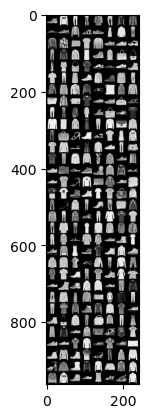

In [4]:
# Do not change this cell
dataiter = iter(test_loader)
images, labels = next(dataiter)
# Show images
imshow(torchvision.utils.make_grid(images))

In [18]:
# TODO: you will design your model here
import torch.nn.functional as F

class ConvModel(nn.Module):
    def __init__(self, input_size, output_size):
        # TODO: complete this method
        super(ConvModel, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc_input_size = 64 * (input_size//4) * (input_size//4)
        self.fc1 = nn.Linear(self.fc_input_size, 128)
        self.fc2 = nn.Linear(128, output_size)

    def forward(self, x):
        # TODO: complete this method
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, self.fc_input_size)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x

In [19]:
def train_step(model, train_loader, loss_fn, optimizer, reg_param, device):
    # TODO: implement one epoch of training
    model.train()
    total_loss = 0
    correct = 0
    total_samples = 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        
        #backward pass
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum().item()
        total_samples += labels.size(0)

    average_loss = total_loss / len(train_loader)
    accuracy = correct / total_samples

    return average_loss, accuracy

In [20]:
def evaluation_step(model, data_loader, loss_fn, reg_param, device):
    # TODO: implement evaluation on a data set, data_loader 
    model.eval()
    total_loss = 0
    correct = 0
    total_samples = 0
    
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
        
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
            total_samples += labels.size(0)

    average_loss = total_loss / len(data_loader)
    accuracy = correct / total_samples

    return average_loss, accuracy

In [67]:
def train_conv_model(train_loader, valid_loader, test_loader, random_seed):
    # Make device
    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda"
    else:
        if torch.backends.mps.is_available():
            device = "mps"

    torch.manual_seed(random_seed)  # do not change this

    # TODO: write codes to train your model here
    train_accuracies, valid_accuracies, test_accuracies = [], [], []
    train_losses, valid_losses, test_losses = [], [], []
    
    input_size = 28
    output_size = 10
    conv_model = ConvModel(input_size, output_size)
    conv_model.to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(conv_model.parameters(), lr=0.001)
    num_epochs = 300

    for epoch in range(num_epochs):
        # Training step
        train_loss, train_accuracy = train_step(conv_model, train_loader, criterion, optimizer, 
                                                reg_param=None, device=device)
        # Validation step
        val_loss, val_accuracy = evaluation_step(conv_model, valid_loader, criterion, reg_param=None, device=device)
        
        # Test step (optional)
        test_loss, test_accuracy = evaluation_step(conv_model, test_loader, criterion, reg_param=None, device=device)

        # Store accuracy and loss values
        train_accuracies.append(train_accuracy)
        valid_accuracies.append(val_accuracy)

        train_losses.append(train_loss)
        valid_losses.append(val_loss)

        # Only append test values if available
        if test_accuracy is not None:
            test_accuracies.append(test_accuracy)
        if test_loss is not None:
            test_losses.append(test_loss)

        # Print and log training and validation metrics
        print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy * 100:.2f}%")
        print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy * 100:.2f}%")

    # Evaluation on the test set (optional)
    if test_accuracy is not None:
        print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy * 100:.2f}%")

    # Return the trained model and the collected values
    return conv_model, train_losses, train_accuracies, valid_losses, valid_accuracies, test_losses, test_accuracies

In [68]:
def plot_accuracy_performance(train_accuracies, valid_accuracies, test_accuracies):
    # TODO: plot accuracy curves, you can reuse your codes from the simple classification task 
    epochs = range(1, len(train_accuracies) + 1)
    plt.plot(epochs, train_accuracies, label='Train')
    plt.plot(epochs, valid_accuracies, label='Valid')
    plt.plot(epochs, test_accuracies, label='Test')
    
    plt.legend()
    plt.show()

In [69]:
def plot_loss_performance(train_losses, valid_accuracies, test_losses):
    # TODO: plot loss curves, you can reuse your codes from the simple classification task
    epochs = range(1, len(train_accuracies) + 1)
    plt.plot(epochs, train_losses, label='Train')
    plt.plot(epochs, valid_losses, label='Valid')
    plt.plot(epochs, test_losses, label='Test')
    
    plt.legend()
    plt.show()

In [70]:
# Do not change this cell
random_seed = 1
model, train_losses, train_accuracies, valid_losses, valid_accuracies, test_losses, test_accuracies\
= train_conv_model(train_loader, valid_loader, test_loader, random_seed)

Epoch 1/300, Train Loss: 0.6518, Train Accuracy: 76.80%
Validation Loss: 0.4459, Validation Accuracy: 83.91%
Epoch 2/300, Train Loss: 0.3820, Train Accuracy: 86.30%
Validation Loss: 0.3588, Validation Accuracy: 87.10%
Epoch 3/300, Train Loss: 0.3286, Train Accuracy: 88.18%
Validation Loss: 0.3053, Validation Accuracy: 89.11%
Epoch 4/300, Train Loss: 0.2908, Train Accuracy: 89.55%
Validation Loss: 0.2842, Validation Accuracy: 89.68%
Epoch 5/300, Train Loss: 0.2716, Train Accuracy: 90.19%
Validation Loss: 0.2899, Validation Accuracy: 89.17%
Epoch 6/300, Train Loss: 0.2521, Train Accuracy: 90.80%
Validation Loss: 0.2960, Validation Accuracy: 89.08%
Epoch 7/300, Train Loss: 0.2357, Train Accuracy: 91.40%
Validation Loss: 0.2961, Validation Accuracy: 89.09%
Epoch 8/300, Train Loss: 0.2225, Train Accuracy: 91.85%
Validation Loss: 0.2452, Validation Accuracy: 91.00%
Epoch 9/300, Train Loss: 0.2063, Train Accuracy: 92.41%
Validation Loss: 0.2369, Validation Accuracy: 91.19%
Epoch 10/300, Train

Epoch 76/300, Train Loss: 0.0001, Train Accuracy: 100.00%
Validation Loss: 0.6069, Validation Accuracy: 92.42%
Epoch 77/300, Train Loss: 0.0001, Train Accuracy: 100.00%
Validation Loss: 0.6172, Validation Accuracy: 92.41%
Epoch 78/300, Train Loss: 0.1150, Train Accuracy: 96.26%
Validation Loss: 0.4144, Validation Accuracy: 91.96%
Epoch 79/300, Train Loss: 0.0400, Train Accuracy: 98.48%
Validation Loss: 0.4482, Validation Accuracy: 91.92%
Epoch 80/300, Train Loss: 0.0129, Train Accuracy: 99.57%
Validation Loss: 0.4810, Validation Accuracy: 92.13%
Epoch 81/300, Train Loss: 0.0058, Train Accuracy: 99.85%
Validation Loss: 0.4818, Validation Accuracy: 91.93%
Epoch 82/300, Train Loss: 0.0059, Train Accuracy: 99.86%
Validation Loss: 0.5045, Validation Accuracy: 91.92%
Epoch 83/300, Train Loss: 0.0028, Train Accuracy: 99.96%
Validation Loss: 0.5181, Validation Accuracy: 92.16%
Epoch 84/300, Train Loss: 0.0008, Train Accuracy: 100.00%
Validation Loss: 0.5224, Validation Accuracy: 92.20%
Epoch 8

Epoch 150/300, Train Loss: 0.0000, Train Accuracy: 100.00%
Validation Loss: 0.6921, Validation Accuracy: 92.40%
Epoch 151/300, Train Loss: 0.0000, Train Accuracy: 100.00%
Validation Loss: 0.6972, Validation Accuracy: 92.38%
Epoch 152/300, Train Loss: 0.0000, Train Accuracy: 100.00%
Validation Loss: 0.7031, Validation Accuracy: 92.43%
Epoch 153/300, Train Loss: 0.0000, Train Accuracy: 100.00%
Validation Loss: 0.7056, Validation Accuracy: 92.43%
Epoch 154/300, Train Loss: 0.0000, Train Accuracy: 100.00%
Validation Loss: 0.7134, Validation Accuracy: 92.43%
Epoch 155/300, Train Loss: 0.0000, Train Accuracy: 100.00%
Validation Loss: 0.7157, Validation Accuracy: 92.43%
Epoch 156/300, Train Loss: 0.0000, Train Accuracy: 100.00%
Validation Loss: 0.7219, Validation Accuracy: 92.52%
Epoch 157/300, Train Loss: 0.0000, Train Accuracy: 100.00%
Validation Loss: 0.7288, Validation Accuracy: 92.46%
Epoch 158/300, Train Loss: 0.0000, Train Accuracy: 100.00%
Validation Loss: 0.7339, Validation Accuracy:

Epoch 224/300, Train Loss: 0.0000, Train Accuracy: 100.00%
Validation Loss: 0.6920, Validation Accuracy: 92.33%
Epoch 225/300, Train Loss: 0.0000, Train Accuracy: 100.00%
Validation Loss: 0.6972, Validation Accuracy: 92.35%
Epoch 226/300, Train Loss: 0.0000, Train Accuracy: 100.00%
Validation Loss: 0.7022, Validation Accuracy: 92.38%
Epoch 227/300, Train Loss: 0.0000, Train Accuracy: 100.00%
Validation Loss: 0.7050, Validation Accuracy: 92.37%
Epoch 228/300, Train Loss: 0.0000, Train Accuracy: 100.00%
Validation Loss: 0.7097, Validation Accuracy: 92.32%
Epoch 229/300, Train Loss: 0.0000, Train Accuracy: 100.00%
Validation Loss: 0.7150, Validation Accuracy: 92.35%
Epoch 230/300, Train Loss: 0.0000, Train Accuracy: 100.00%
Validation Loss: 0.7193, Validation Accuracy: 92.36%
Epoch 231/300, Train Loss: 0.0000, Train Accuracy: 100.00%
Validation Loss: 0.7234, Validation Accuracy: 92.35%
Epoch 232/300, Train Loss: 0.0000, Train Accuracy: 100.00%
Validation Loss: 0.7281, Validation Accuracy:

Epoch 298/300, Train Loss: 0.0000, Train Accuracy: 100.00%
Validation Loss: 1.0346, Validation Accuracy: 92.58%
Epoch 299/300, Train Loss: 0.0000, Train Accuracy: 100.00%
Validation Loss: 1.0389, Validation Accuracy: 92.52%
Epoch 300/300, Train Loss: 0.0000, Train Accuracy: 100.00%
Validation Loss: 1.0444, Validation Accuracy: 92.53%
Test Loss: 1.2975, Test Accuracy: 92.17%


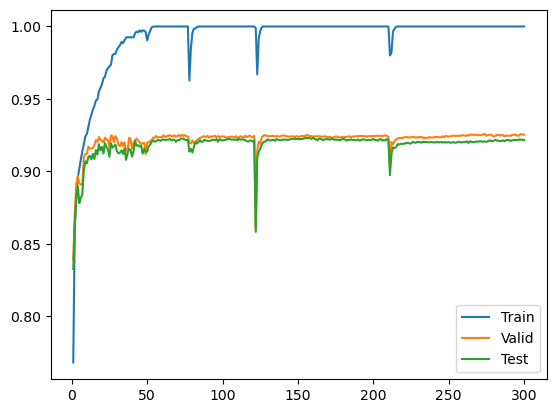

In [71]:
# Do not change this cell
plot_accuracy_performance(train_accuracies, valid_accuracies, test_accuracies)

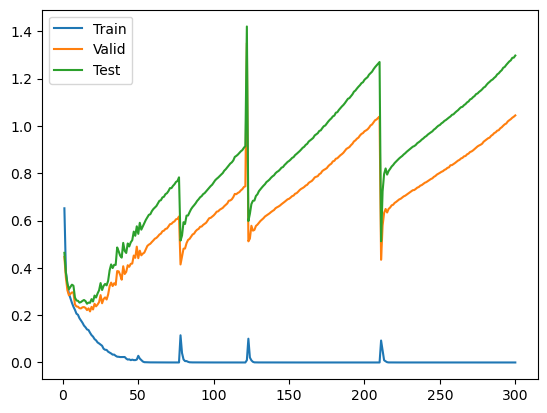

In [72]:
# Do not change this cell
plot_loss_performance(train_losses, valid_losses, test_losses)